# 1. 读取数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

warnings.filterwarnings('ignore')
%matplotlib inline

train = pd.read_csv('../data/f_train.csv')
test = pd.read_csv('../data/f_test.csv')
num2label = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS', 
    3: 'WALKING_DOWNSTAIRS', 
    4: 'SITTING', 
    5: 'STANDING', 
    6: 'LAYING'
    }
label2num = {v: k for k, v in num2label.items()}

X_train = train.drop(['subject', 'activity'], axis=1)
y_train = train['activity'].map(label2num)
X_test = test.drop(['subject', 'activity'], axis=1)
y_test = test['activity'].map(label2num)

# 2. 指标

In [27]:
# 紧密度
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.metrics import adjusted_rand_score, confusion_matrix,  accuracy_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.optimize import linear_sum_assignment

# 紧密度
def compute_compactness(X, labels):
    if not isinstance(X, np.ndarray):
        X = X.values
    unique_labels = np.unique(labels)
    compactness = 0.0
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        cluster_center = cluster_points.mean(axis=0)  # 计算质心
        compactness += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1))  # 簇内距离总和
    return compactness

# 分离度
def compute_separation(X, labels):
    if not isinstance(X, np.ndarray):
        X = X.values
    unique_labels = np.unique(labels)
    cluster_centers = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        cluster_centers.append(cluster_points.mean(axis=0))  # 计算质心
    cluster_centers = np.array(cluster_centers)
    pairwise_dist = pairwise_distances(cluster_centers)  # 质心两两之间的距离
    np.fill_diagonal(pairwise_dist, np.inf)  # 忽略自身到自身的距离（置为无穷大）
    return pairwise_dist.min()

# 准确率
def cluster_accuracy(true_labels, labels):
    conf_matrix = confusion_matrix(true_labels, labels + 1)
    print(conf_matrix)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    print(row_ind, col_ind)
    mapping = dict(zip(col_ind, row_ind))
    mapped_labels = np.array([mapping[label] for label in labels])
    accuracy = accuracy_score(true_labels, mapped_labels)
    return accuracy
def print_metrics(X, labels, true_labels):
    # 内在指标
    print('Internal Indices')
    # 紧凑度
    compactness = compute_compactness(X, labels)
    print(f'compactness:{compactness: .3f}')

    # 分离度
    separation = compute_separation(X, labels)
    print(f'separation:{separation: .3f}')

    # 衡量簇内点的紧密度与簇间点的分离度，取值范围：[-1, 1]，值越接近 1，说明聚类效果越好。
    if len(np.unique(labels)) == 1:
        SC = 0
    else:
        SC = silhouette_score(X, labels)  
    print(f'Silhouette Coefficient:{SC: .3f}')

    # # 衡量簇间方差和簇内方差的比值，值越大，说明簇间分离度大，簇内紧密度高。
    # CH = calinski_harabasz_score(X, labels)  
    # print(f'Calinski-Harabasz Index:{CH: .3f}')

    # # 衡量簇间距离和簇内距离的比值，值越小，说明聚类效果越好
    # DB = davies_bouldin_score(X, labels) 
    # print(f'Davies-Bouldin Index:{DB: .3f}\n')


    # 外在指标
    print('External Indices:')

    if len(np.unique(labels)) != 6:
        acc = None
        print('Accuracy: ', acc)
    else:
        acc = cluster_accuracy(true_labels, labels)
        print(f'Accuracy:{acc: .3f}')

    # 取值范围：[-1, 1]，值越接近 1，说明聚类结果与真实标签一致性越高。
    ARI = adjusted_rand_score(true_labels, labels) 
    print(f'Adjusted Rand Index:{ARI: .3f}')

    # #取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
    # MI = normalized_mutual_info_score(true_labels, labels) 
    # print(f'Mutual Information:{MI: .3f}')

    #取值范围：[0, 1]，值越高说明聚类结果与真实标签一致性越高。
    # FMI = fowlkes_mallows_score(true_labels, labels)
    # print(f'FMI:{FMI: .3f}')
    return compactness, separation, SC, acc, ARI

# 3. 密度聚类

### 3.1 DBSCAN 
(Density-Based Spatial Clustering of Applications with Noise)

- 原理：
    - 定义一个点的邻域范围𝜖和最小点数min_samples。
    - 如果一个点的邻域范围内点的数量大于等于min_samples，则该点被认为是核心点，并与其邻域范围内的点形成一个簇。
    - 非核心点若在某核心点的邻域范围内，则归属于该簇；否则标记为噪声点。
- 优点：
    - 能发现任意形状的簇。
    - 对噪声点具有鲁棒性。
- 缺点：
    - 需要调节超参数 
    - 𝜖和min_samples，在不同数据集上较难优化。

In [21]:
from sklearn import neighbors
from sklearn.pipeline import Pipeline
# from sklearn.cluster import DBSCAN
from pyclustering.cluster.dbscan import dbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

param_grid = {
    'standard_scaler': [True, False],
    'pca__n_components': [0.8, 0.9, False],
    'dbscan__eps': [2.0, 3.0, 5.0],
    'dbscan__neighbors': [3, 5]
}

best_score = -1
best_params = {}
run_times = []
# 循环遍历参数网格
for standard_scaler in param_grid['standard_scaler']:
    for n_components in param_grid['pca__n_components']:
        for eps in param_grid['dbscan__eps']:
            for neighbors in param_grid['dbscan__neighbors']:
                if standard_scaler and n_components:
                    pp = Pipeline([
                        ('sc', StandardScaler()),
                        ('pca', PCA(n_components=n_components)),
                    ])
                elif not standard_scaler and n_components:
                    pp = PCA(n_components=n_components)
                elif not n_components:
                    pp = None

                if pp:
                    X_pca = pp.fit_transform(X_train)
                else:
                    X_pca = X_train.values

                model = dbscan(X_pca.tolist(), eps=eps, neighbors=neighbors)
                
                # 拟合模型并预测
                start_time = time.time()
                model.process()
                run_times.append(time.time() - start_time)

                clusters = model.get_clusters()
                labels = np.full(X_pca.shape[0], -1)
                for cluster_id, cluster in enumerate(clusters):
                    labels[cluster] = cluster_id

                # 计算 adjusted rand score
                score = adjusted_rand_score(y_train, labels)
                
                # 更新最佳参数和评分
                if score > best_score:
                    best_score = score
                    best_params = {
                        'standard_scaler': standard_scaler,
                        'pca__n_components': n_components,
                        'dbscan_eps': eps,
                        'dbscan_neighbors': neighbors
                    }
                    best_model = model

# 输出最佳参数和评分
print("Best parameters found: ", best_params)
print("Best adjusted rand score: ", best_score)
print(f"Average run time: {np.mean(run_times):.2f} ± {np.std(run_times):.2f} seconds")


Best parameters found:  {'standard_scaler': False, 'pca__n_components': 0.8, 'dbscan_eps': 2.0, 'dbscan_neighbors': 3}
Best adjusted rand score:  0.3297715450909557
Average run time: 11.19 ± 13.41 seconds


Internal Indices
compactness: 24387.328
separation: 3.869
Silhouette Coefficient: 0.504
External Indices:
Accuracy:  None
Adjusted Rand Index: 0.330


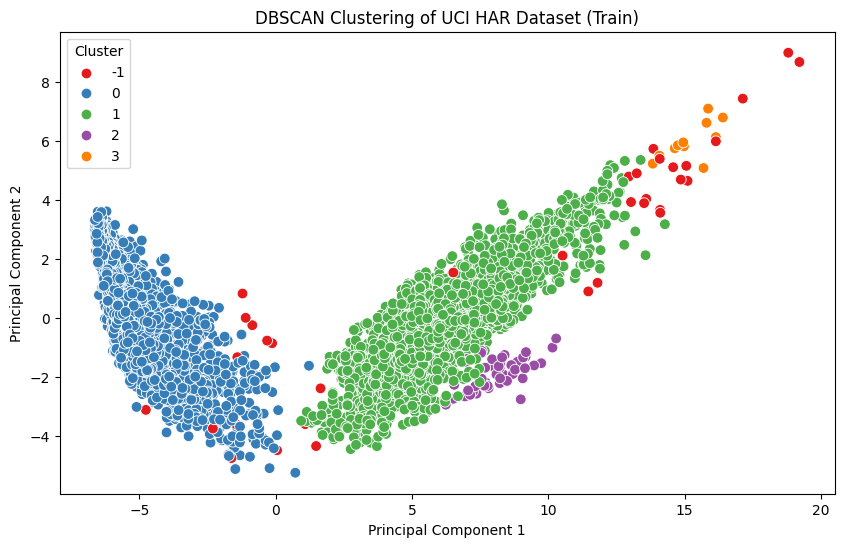

In [28]:
'''
Best parameters:  
{
'standard_scaler': False, 
'pca__n_components': 0.8, 
'dbscan_eps': 2.0, 
'dbscan_neighbors': 3
}
'''

# 使用最佳参数进行聚类

pp = Pipeline([
    # ('sc', StandardScaler()),
    ('pca', PCA(n_components=0.8))
])
X_train_pca = pp.fit_transform(X_train)
# best_model = dbscan(X_train_pca.tolist(), eps = 2.0, neighbors = 5)
# model.process()

clusters = best_model.get_clusters()
y_pred = np.full(X_train_pca.shape[0], -1)
for cluster_id, cluster in enumerate(clusters):
    y_pred[cluster] = cluster_id

compactness, separation, SC, acc, ARI = print_metrics(X_train_pca, y_pred, y_train)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_pred, palette="Set1", s=60)
plt.title("DBSCAN Clustering of UCI HAR Dataset (Train)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.savefig("../result/dbscan_best.pdf")
plt.show()